In [1]:

from scipy.misc import imread
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.externals import joblib
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle
from functions import *



In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
# load data, ndarrays generated from images
import pickle
image_file = "course_images.p"
label_file = "course_labels.p"
X = None
Y = None
with open(image_file, "rb") as f:
    X = pickle.load(f)
with open(label_file, "rb") as f:
    Y = pickle.load(f)


In [4]:
# split data
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=rand_state)

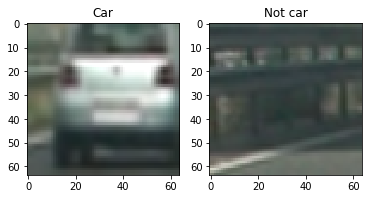

In [15]:
# have a look at the training images
car = Y > 0
not_car = Y <= 0
X_car = X[car]
X_not_car = X[not_car]
plt.subplot(121)
plt.imshow(X_car[100])
plt.title("Car")
plt.subplot(122)
plt.imshow(X_not_car[100])
plt.title("Not car")
plt.savefig("./output_images/car_not_car.jpg")

In [7]:
# augment data
# flip hirizontally
X_train_flip_h = np.zeros_like(X_train)
for i in np.arange(X_train.shape[0]):
    X_train_flip_h[i] = cv2.flip(X_train[i], 1)
# concatenate together with original
X_train = np.vstack((X_train, X_train_flip_h))
y_train = np.concatenate((y_train, y_train))
# augment brightness
X_train_ab1 = np.zeros_like(X_train)
X_train_ab2 = np.zeros_like(X_train)
for i in np.arange(X_train.shape[0]):
    X_train_ab1[i] = augment_brightness(X_train[i])
    X_train_ab2[i] = augment_brightness(X_train[i])
# concatenate togethor
X_train = np.vstack((X_train_ab1, X_train_ab2))
y_train = np.concatenate((y_train, y_train))

# augment size
X_train_size = np.zeros_like(X_train)
for i in np.arange(X_train.shape[0]):
    X_train_size[i] = augment_rescale(X_train[i])
# concatenate together
X_train = np.vstack((X_train, X_train_size))
y_train = np.concatenate((y_train, y_train))

In [8]:
# cell 8

# define feature extraction parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features 

# extract features
features = extract_features_from_array(X_train, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=spatial_feat, hist_feat=True, hog_feat=True)

In [87]:
# cell 9
# normalize data

X_scaler = StandardScaler().fit(features)
scaled_X = X_scaler.transform(features)
# scaled_X_pc = pca.transform(scaled_X)
scaled_X_pc = scaled_X

In [88]:
# cell 10
# applying priciple component analysic
# from sklearn.decomposition import PCA
# pca = PCA(n_components=300)
# pca.fit(scaled_X)

In [91]:
# cell 11
# extract features form images in test set
X_test_feature = extract_features_from_array(X_test, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                     spatial_feat=spatial_feat, hist_feat=True, hog_feat=True)


scaled_X_test = X_scaler.transform(X_test_feature)

In [92]:
# cell12
# search for a good parameter for C

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(scaled_X_pc[0]))
# Use a linear SVC 
c_values = np.logspace(0.001, 1, num = 2)
c_values = np.concatenate((c_values / 100, c_values / 10))
best_test_accuracy = 0
best_C = None
for i in range(c_values.shape[0]):
    C = c_values[i]
    svc = LinearSVC(max_iter=5000, C = C)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(scaled_X_pc, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    train_accuracy = svc.score(scaled_X_pc, y_train)
    test_accuracy = svc.score(scaled_X_test, y_test)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_C = C
    print("Train Accuracy of SVC = ", round(train_accuracy, 4))
    print('Test Accuracy of SVC = ', round(test_accuracy, 4))
    # Check the prediction time for a single sample
    t=time.time()
print("Best test accuracy is: {}".format(best_test_accuracy))
print("Best C is: {}".format(best_C))

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1068
645.69 Seconds to train SVC...
Train Accuracy of SVC =  0.9877
Test Accuracy of SVC =  0.9844
810.79 Seconds to train SVC...
Train Accuracy of SVC =  0.9878
Test Accuracy of SVC =  0.984
792.19 Seconds to train SVC...
Train Accuracy of SVC =  0.9878
Test Accuracy of SVC =  0.984
1382.91 Seconds to train SVC...
Train Accuracy of SVC =  0.9876
Test Accuracy of SVC =  0.985
Best test accuracy is: 0.984984984984985
Best C is: 1.0


In [4]:
# train linearsvm model with best parameter found
svc = LinearSVC(max_iter=5000, C = best_C)
    # Check the training time for the SVC

svc.fit(scaled_X_pc, y_train)

NameError: name 'best_C' is not defined

In [95]:
# dump data normalization and linear svm model to file for later use
from sklearn.externals import joblib


joblib.dump(X_scaler, 'feature_scaler2.pkl') 
# joblib.dump(pca, "pca2.pkl")
joblib.dump(svc, 'svm_classifier2.pkl') 

['svm_classifier2.pkl']

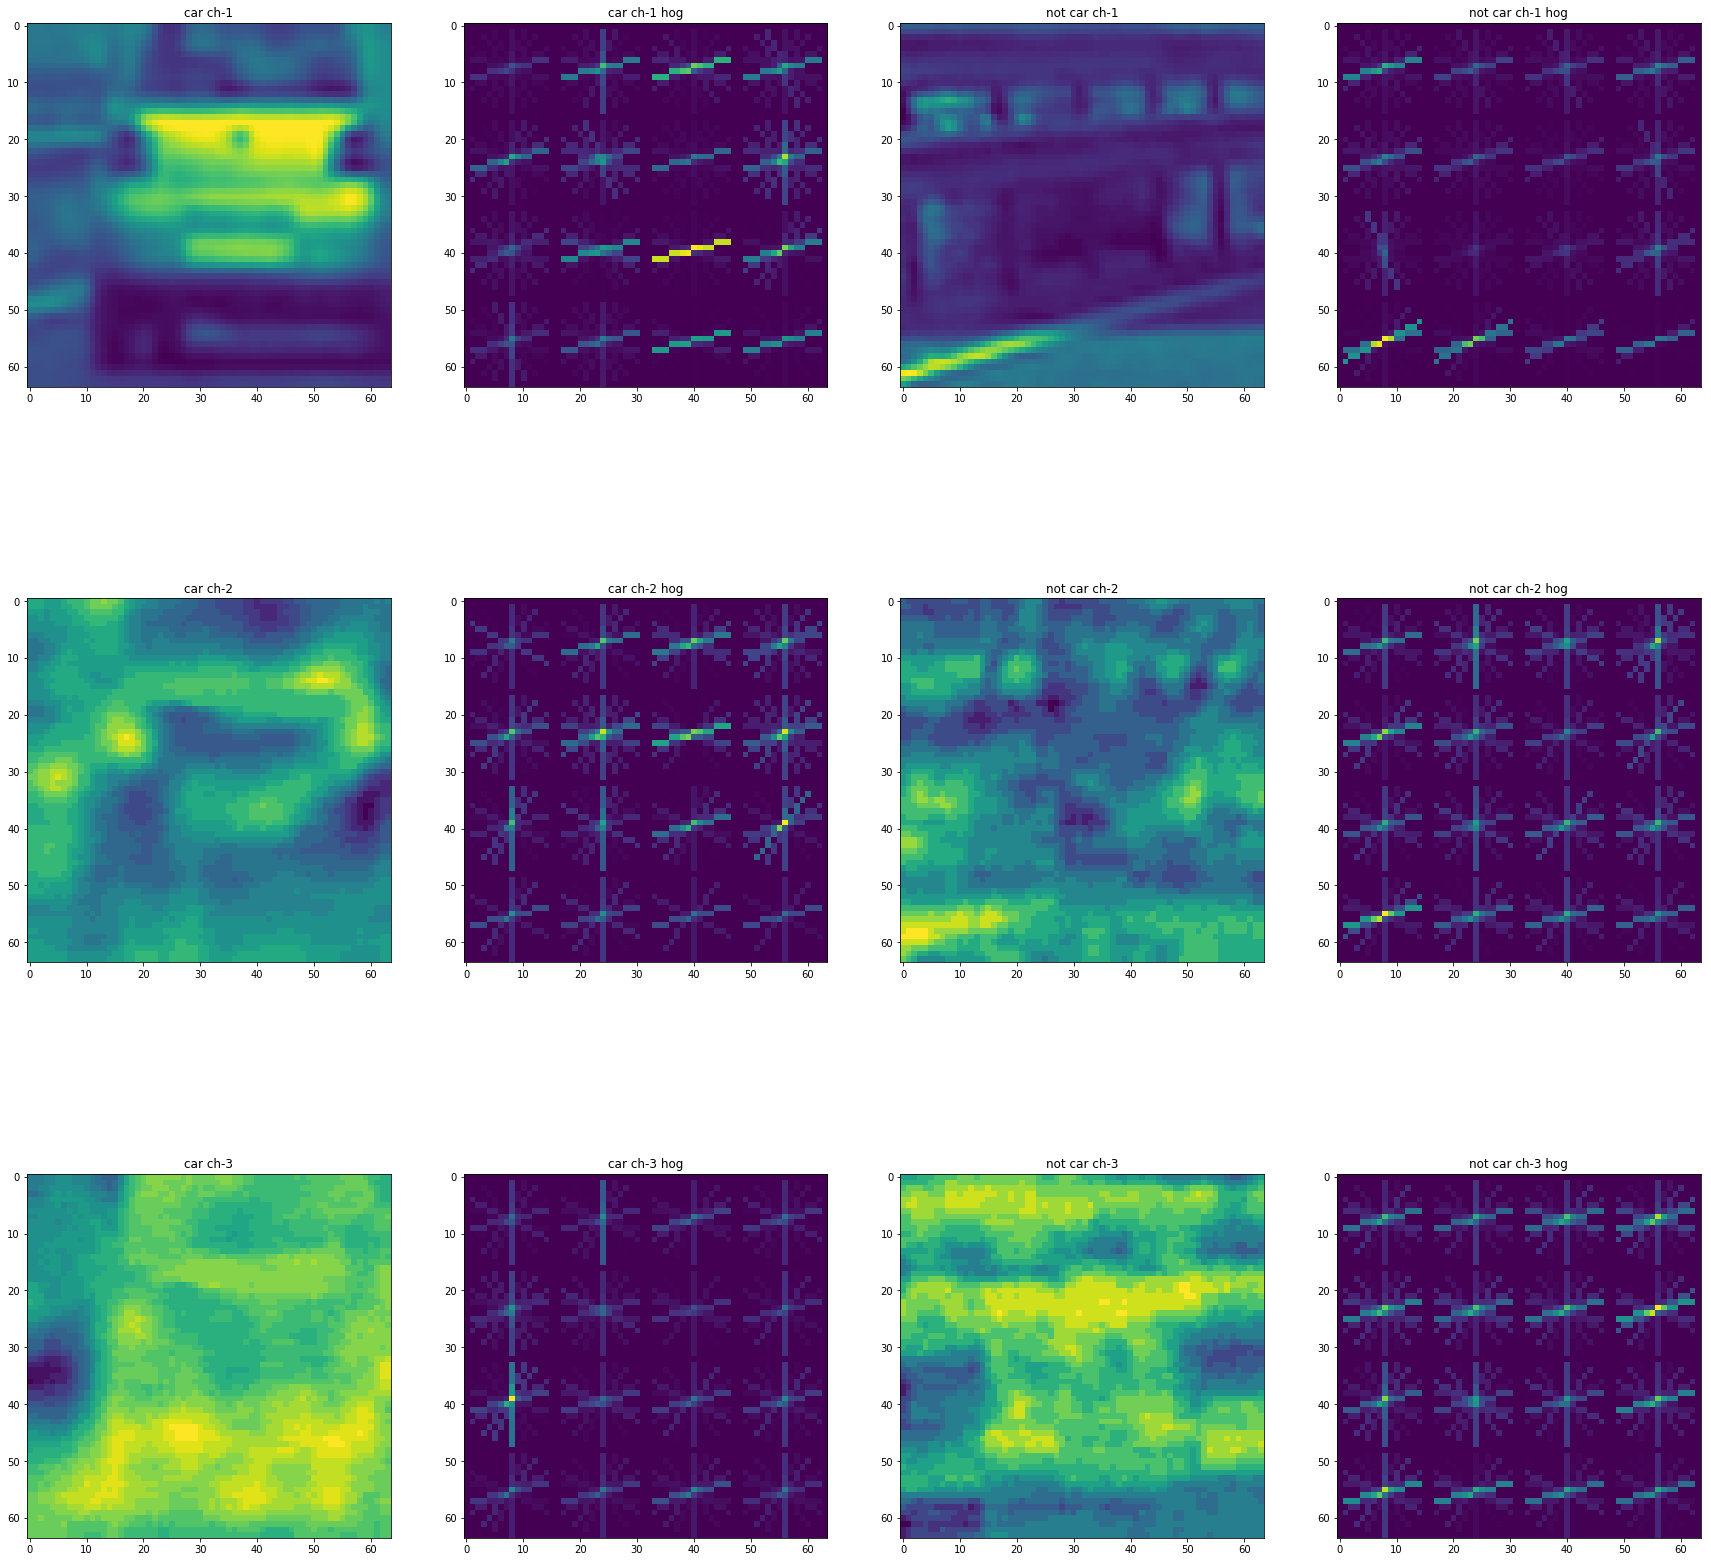

In [30]:
car = X_car[100]
not_car = X_not_car[100]
# convert to YUV color space
car_yuv = cv2.cvtColor(car, cv2.COLOR_RGB2YUV)
not_car_yuv = cv2.cvtColor(not_car, cv2.COLOR_RGB2YUV)
car_hog = []
not_car_hog = []
for i in range(3):
    car_hog.append(get_hog_features(car_yuv[:,:,i], orient=9, cell_per_block=2, pix_per_cell=16, vis= True))
    not_car_hog.append(get_hog_features(not_car_yuv[:,:,i], orient=9, cell_per_block=2, pix_per_cell=16, vis=True))

plt.figure(figsize = (30, 30))
for i in range(3):
    plt.subplot(3, 4, 1 + i * 4)
    plt.imshow(car_yuv[:,:,i])
    plt.title("car ch-{}".format(i + 1))
    plt.subplot(3, 4, 2 + i * 4)
    plt.imshow(car_hog[i][1])
    plt.title("car ch-{} hog".format(i + 1))

    plt.subplot(3, 4, 3 + i * 4)
    plt.imshow(not_car_yuv[:,:,i])
    plt.title("not car ch-{}".format(i + 1))
    plt.subplot(3, 4, 4 + i * 4)
    plt.imshow(not_car_hog[i][1])
    plt.title("not car ch-{} hog".format(i + 1))


plt.savefig("./output_images/hogs.jpg")

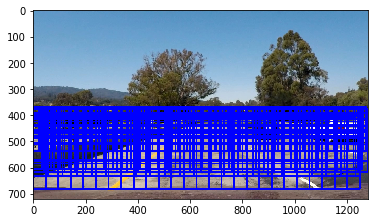

In [44]:
# sliding windows
obj = CVehicleDetector()
windows =  obj.windows
img = imread("./test_images/test1.jpg")
for (x1, y1), (x2, y2) in windows:
    cv2.rectangle(img, (x1, y1 + 360), (x2, y2 + 360), (0, 0, 255), 6)
plt.imshow(img)
plt.savefig("./output_images/sliding_windows.jpg")

/Users/michael/Documents/learn/self-driving-car/assignments/vehicle_tracking/functions.py:599: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bottom_half = image[image.shape[0] / 2: image.shape[0], :, :]


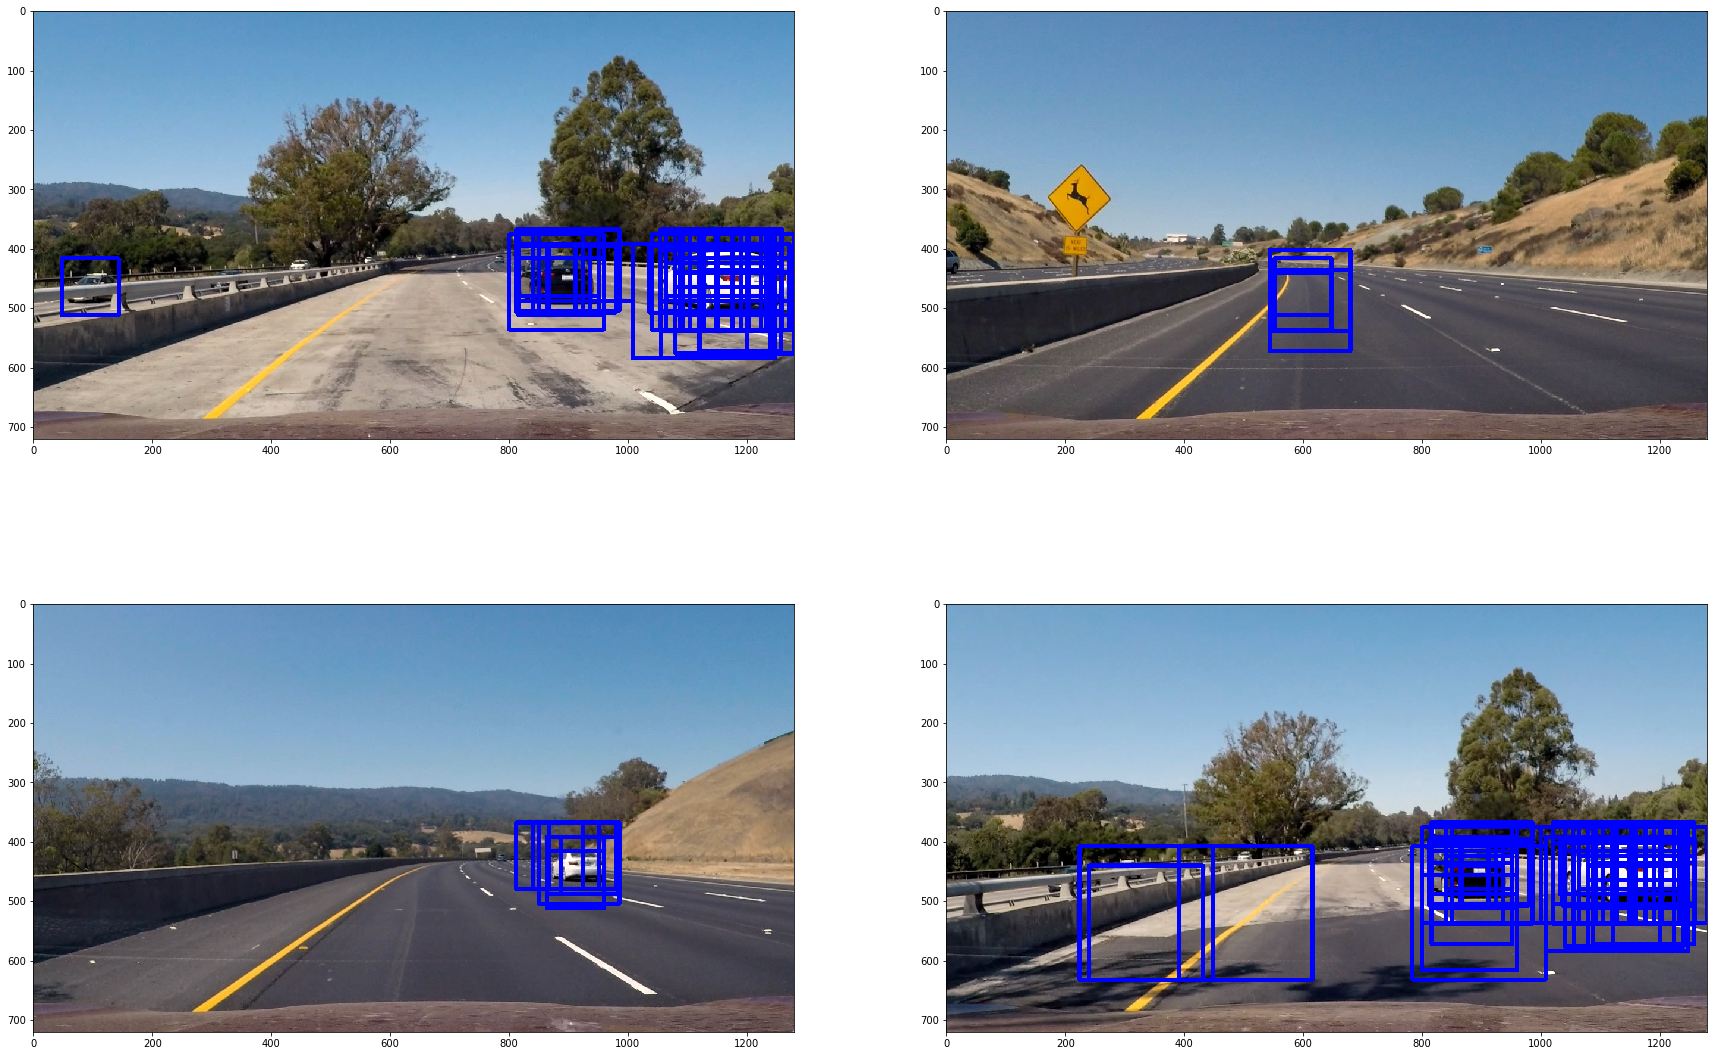

In [51]:
# sliding window
plt.figure(figsize=(30,20))
for i in range(4):
    img = imread("./test_images/test{}.jpg".format(i + 1))

    obj.feed_image(img)
    sliding_window_img, heat_img = obj.get_boxes_img()
    plt.subplot(2,2,i+1)
    plt.imshow(sliding_window_img)
plt.savefig("./output_images/sliding_window.jpg")

[MoviePy] >>>> Building video project_video_out2.mp4
[MoviePy] Writing video project_video_out2.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  1%|          | 12/1261 [00:00<00:10, 118.26it/s]


  2%|▏         | 28/1261 [00:00<00:09, 127.04it/s]


  3%|▎         | 43/1261 [00:00<00:09, 131.05it/s]


  4%|▍         | 53/1261 [00:00<00:13, 86.89it/s] 


  5%|▍         | 61/1261 [00:00<00:16, 73.73it/s]


  5%|▌         | 69/1261 [00:00<00:17, 66.52it/s]


  6%|▌         | 76/1261 [00:00<00:18, 63.68it/s]


  7%|▋         | 83/1261 [00:01<00:19, 61.94it/s]


  7%|▋         | 90/1261 [00:01<00:19, 58.78it/s]


  8%|▊         | 97/1261 [00:01<00:20, 58.09it/s]


  8%|▊         | 103/1261 [00:01<00:20, 57.17it/s]


  9%|▊         | 109/1261 [00:01<00:20, 55.38it/s]


  9%|▉         | 115/1261 [00:01<00:20, 55.99it/s]


 10%|▉         | 121/1261 [00:01<00:21, 52.92it/s]


 10%|█         | 128/1261 [00:01<00:20, 54.89it/s]


 11%|█         | 134/1261 [00:02<00:22, 50.75it/s]


 11%|█         | 140/1261 [00:02<00:21, 51.26it/s]


 12%|█▏        | 146/1261 [00:02<00:21, 52.02it/s]


 12%|█

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>





 39%|███▉      | 498/1261 [00:19<00:29, 26.13it/s]


 40%|███▉      | 504/1261 [00:20<07:26,  1.70it/s]


 41%|████      | 513/1261 [00:20<05:11,  2.40it/s]


 41%|████      | 520/1261 [00:20<03:39,  3.38it/s]


 42%|████▏     | 527/1261 [00:20<02:35,  4.73it/s]


 42%|████▏     | 532/1261 [00:20<01:53,  6.44it/s]


 43%|████▎     | 539/1261 [00:20<01:21,  8.81it/s]


 43%|████▎     | 546/1261 [00:20<01:00, 11.90it/s]


 44%|████▍     | 552/1261 [00:20<00:45, 15.53it/s]


 44%|████▍     | 558/1261 [00:20<00:35, 19.95it/s]


 45%|████▍     | 564/1261 [00:20<00:27, 24.94it/s]


 45%|████▌     | 570/1261 [00:21<00:24, 28.50it/s]


 46%|████▌     | 576/1261 [00:21<00:21, 32.22it/s]


 46%|████▌     | 582/1261 [00:21<00:19, 35.37it/s]


 47%|████▋     | 588/1261 [00:21<00:17, 39.46it/s]


 47%|████▋     | 595/1261 [00:21<00:15, 44.34it/s]


 48%|████▊     | 601/1261 [00:21<00:15, 43.32it/s]


 48%|████▊     | 607/1261 [00:21<00:14, 45.77it/s]


 49%|████▊     | 613/1261 [00:21<00:13, 47.

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2.mp4 



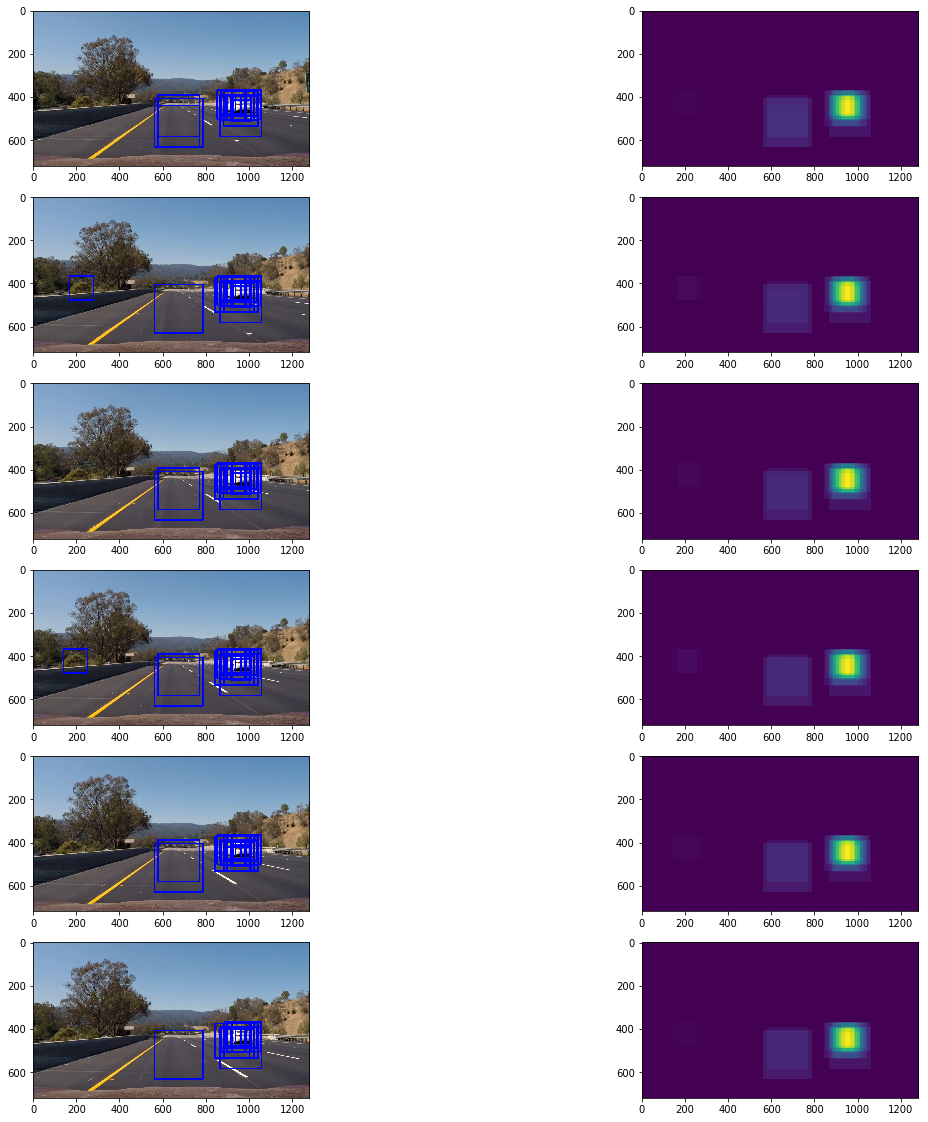

In [67]:
plt.figure(figsize=(20, 20))

from moviepy.editor import VideoFileClip
def num_generator_fun():
    n = 0
    while True:
        n += 1
        yield n
num_generator = num_generator_fun()
def process_image(img):
    """
    detect cars in img
    :param img:
    :return:
    """
    detector = CVehicleDetector()
    frame_count = next(num_generator)
    if frame_count >= 500 and frame_count <= 505:
        
        detector.feed_image(img)
        print(type(detector.get_boxes_img()))
        box_img, heat_img = detector.get_boxes_img()
        plt.subplot(6, 2, (frame_count - 500) * 2 + 1)
        plt.imshow(box_img)
        plt.subplot(6, 2, (frame_count - 500) * 2 + 2)
        plt.imshow(heat_img)
        plt.savefig("./output_images/boxes_and_heat.jpg")
    return img
    


def process_video(name):
    """process video to detect cars in the image"""
    file_in = name + ".mp4"
    file_out = name + "_out2.mp4"
    clip1 = VideoFileClip(file_in)
    white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
    white_clip.write_videofile(file_out, audio=False)

process_video("project_video")

/Users/michael/Documents/learn/self-driving-car/assignments/vehicle_tracking/functions.py:599: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bottom_half = image[image.shape[0] / 2: image.shape[0], :, :]


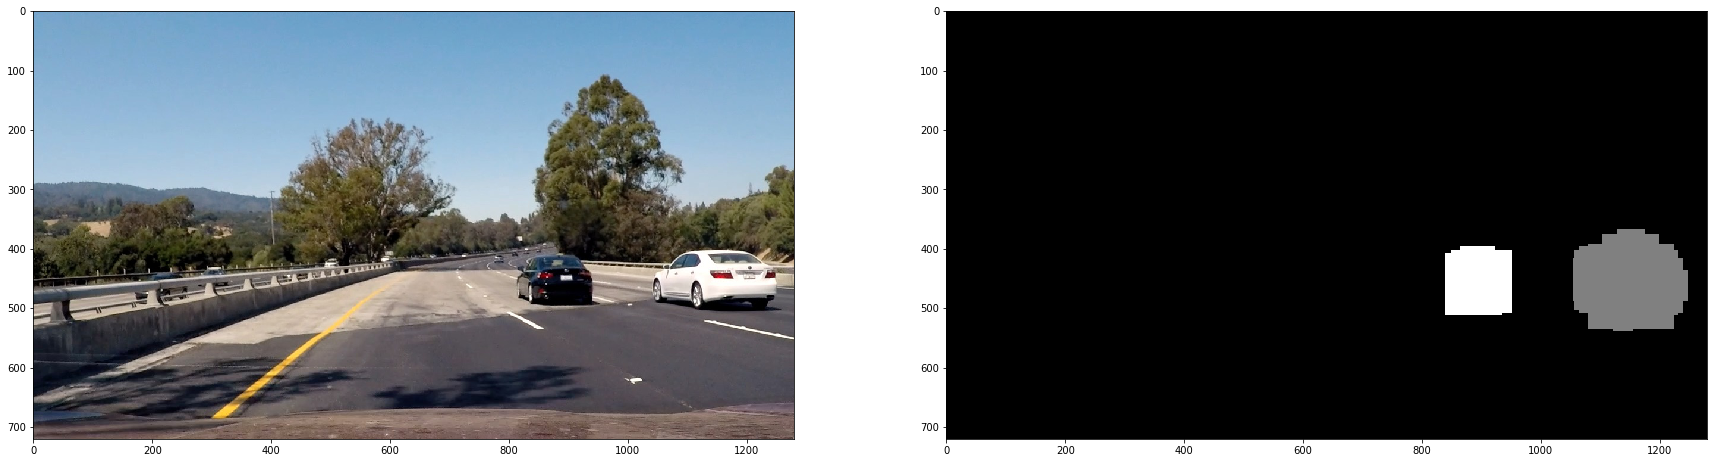

In [10]:
obj = CVehicleDetector()
img = imread("./test_images/test4.jpg")
plt.figure(figsize=(30, 20))
obj.feed_image(img)
label_img = obj.get_labels_map()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(label_img, cmap = "gray")
plt.savefig("./output_images/label.jpg")

/Users/michael/Documents/learn/self-driving-car/assignments/vehicle_tracking/functions.py:599: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bottom_half = image[image.shape[0] / 2: image.shape[0], :, :]


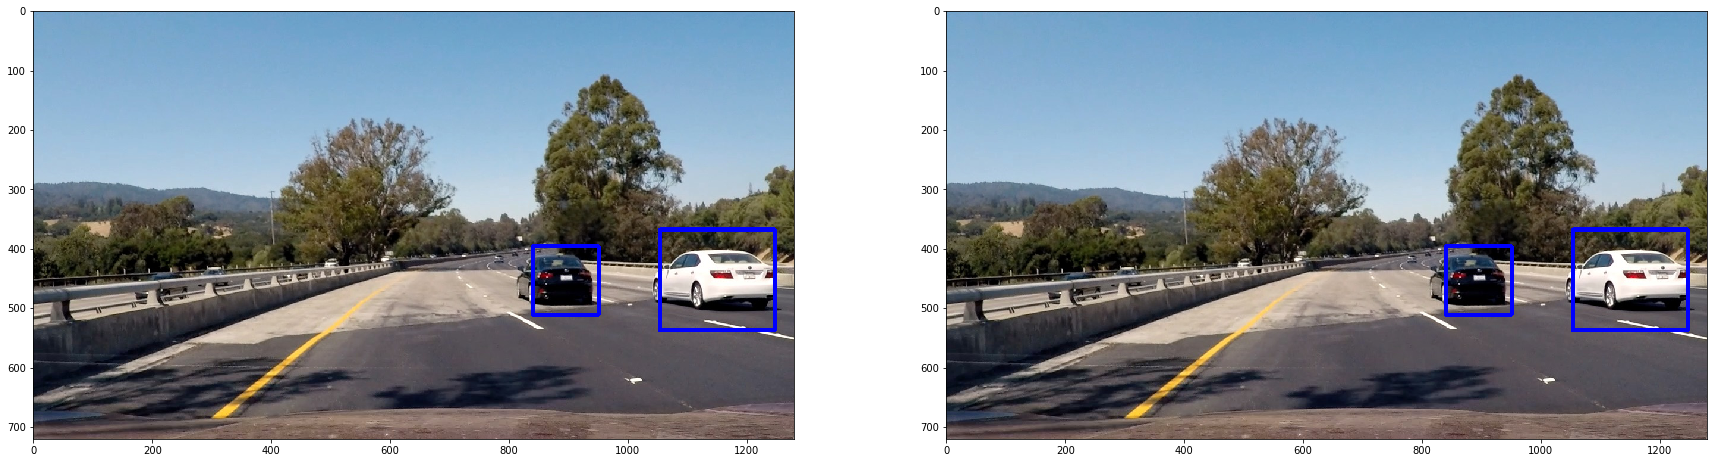

In [11]:
obj = CVehicleDetector()
img = imread("./test_images/test4.jpg")
plt.figure(figsize=(30, 20))

obj.feed_image(img)
label_img = obj.get_detected_cars()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(label_img)
plt.savefig("./output_images/bboxes.jpg")